In [126]:
import numpy as np
import matplotlib.pyplot as plt


In [127]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
import torch
from neurodiffeq.conditions import IBVP1D
from neurodiffeq.pde import make_animation
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation

In [128]:
k, L, T = 1, 2, 3
# Define the PDE system
# There's only one (heat) equation in the system, so the function maps (u, x, y) to a single entry
def K_(u):
    return 1+0.5*u
heat = lambda u, x, t: [
    diff(u, t) - K_(u) * diff(u, x, order=2)
]

# Define the initial and boundary conditions
# There's only one function to be solved for, so we only have a single condition object
conditions = [
    IBVP1D(
        t_min=0, t_min_val=lambda x: x*0,
        x_min=0, x_min_prime=lambda t:  -t/(t+0.001*torch.ones_like(t)),
        x_max=L, x_max_prime=lambda t: t*0
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, hidden_units=(100, 100), actv=torch.nn.Tanh)
]


# Define the monitor callback
monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver
solver = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((100, 100), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((100, 100), (0, 0), (L, T), method='equally-spaced'),
    
)

# Fit the neural network
solver.fit(max_epochs=200, callbacks=[lambda x: print(x.global_epoch) if x.global_epoch%10==0 else 1])

# Obtain the solution
solution_neural_net_heat = solver.get_solution()

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


(-1.0, 1.0)

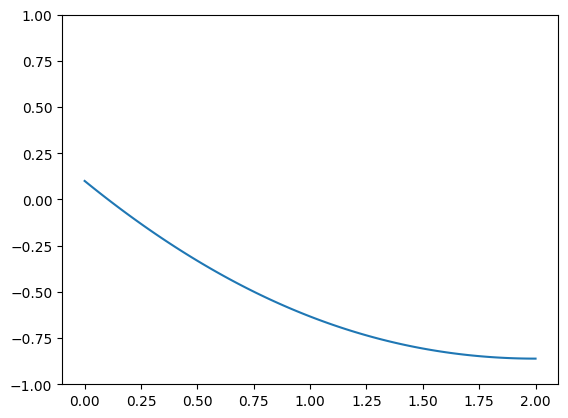

In [132]:

xs = np.linspace(0, L, 101)
ts = np.linspace(0, T, 101)
xx, tt = np.meshgrid(xs, ts)

plt.plot(xx[10],solution_neural_net_heat(xx[10], tt[5]).detach())
plt.ylim((-1,1))